In [1]:
# Mattia Vaccari - http://www.mattiavaccari.net - https://github.com/mattia-vaccari
# IDIA/ilifu - https://idia.ac.za - https://www.ilifu.ac.za - https://github.com/idia-astro

In [2]:
# SciServer @ JHU IDIES
# Web Site - https://www.sciserver.org - https://idies.jhu.edu
# GitHub https://github.com/sciserver
# Stand-Alone Client - https://github.com/sciserver/SciScript-Python
# Example Notebooks - https://github.com/sciserver/Example-Notebooks    

In [10]:
# Authentication

from SciServer import Authentication

#username = '***'
#password = '***'
#login = Authentication.login(username,password)

login = Authentication.login()

token = Authentication.getToken()

Enter SciServer user name:  ········
Enter SciServer password:  ········


In [11]:
# Imports

from io import StringIO
from io import BytesIO

import astropy.io.fits as pf
import numpy as np
import pandas as pd

import itertools
import timeit

from matplotlib import pyplot as plt

from sklearn import metrics
from sklearn.metrics import accuracy_score as acc
from sklearn.model_selection import train_test_split

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor

from SciServer import CasJobs

In [12]:
# Run SciServer Query for Classification Experiment

NOBJECTS = 50000

# Bright Limits : Somewhat Arbitrary
# Faint Limits : Median 5-sigma depths from
# https://www.sdss.org/dr16/imaging/other_info/#DepthsoftheSDSSphotometricsurvey

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND s.zwarning = 0",
    "   AND (s.class = 'STAR' OR s.class = 'GALAXY' OR s.class = 'QSO')")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR16")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning
0,20.38971,20.31459,20.26365,20.02980,19.87909,QSO,BROADLINE,2.068034,0.001411,0
1,19.18999,18.95942,18.83504,18.57838,18.53877,QSO,BROADLINE,1.603607,0.000544,0
2,20.42657,18.46144,17.38508,16.96222,16.62664,GALAXY,NaN,0.158948,0.000025,0
3,18.18210,17.17217,17.00973,16.96856,16.97230,STAR,A0,-0.000282,0.000013,0
4,20.12504,18.41673,17.52799,17.13356,16.78513,GALAXY,NaN,0.082388,0.000027,0
...,...,...,...,...,...,...,...,...,...,...
49995,19.47822,18.33127,17.90816,17.73044,17.66522,STAR,G0,0.000275,0.000016,0
49996,19.35615,19.10180,18.82289,18.73734,18.69226,QSO,BROADLINE,1.008546,0.000423,0
49997,19.13596,18.08025,17.68781,17.38974,17.20050,GALAXY,STARBURST,0.049144,0.000006,0
49998,20.32238,18.60342,17.66389,17.23398,16.88720,GALAXY,NaN,0.081581,0.000027,0


In [13]:
# Extract Data

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

class_in

0           QSO
1           QSO
2        GALAXY
3          STAR
4        GALAXY
          ...  
49995      STAR
49996       QSO
49997    GALAXY
49998    GALAXY
49999    GALAXY
Name: class, Length: 50000, dtype: object

In [14]:
# Source Classification - Assemble Data

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z)]).T

y, c = pd.factorize(class_in)

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.20)

c

Index(['QSO', 'GALAXY', 'STAR'], dtype='object')

In [15]:
# Source Classification - Run kNN Classifier

y_predict = []

start_time = timeit.default_timer()

n_neighbors = 10

ks = KNeighborsClassifier(n_neighbors)
ks.fit(x_train, y_train)  
y_ks = ks.predict(x_test)
elapsed = timeit.default_timer() - start_time
proba = ks.predict_proba(x_test)
y_predict.append(y_ks)
acu = acc(y_test, y_ks)

print('Elapsed time for knn: {} seconds'.format(elapsed))
print(len(y_ks))
print('Accuracy for kNN for k={:} is: {}'.format(n_neighbors,acu))
print(metrics.classification_report(y_test, y_ks, target_names=c, digits=4))

Elapsed time for knn: 0.6382575640454888 seconds
10000
Accuracy for kNN for k=10 is: 0.9639
              precision    recall  f1-score   support

         QSO     0.9352    0.9241    0.9296      1015
      GALAXY     0.9743    0.9835    0.9789      7680
        STAR     0.9221    0.8797    0.9004      1305

    accuracy                         0.9639     10000
   macro avg     0.9439    0.9291    0.9363     10000
weighted avg     0.9635    0.9639    0.9636     10000



In [16]:
# Phot-Z Estimate - SFGs - Data Query

NOBJECTS = 50000

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND s.zwarning = 0",
    "   AND s.class = 'GALAXY'")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR16")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning
0,19.96153,18.04700,17.14440,16.71506,16.37957,GALAXY,NaN,0.054655,0.000015,0
1,20.45875,18.56703,17.49523,17.04447,16.66183,GALAXY,NaN,0.115702,0.000022,0
2,19.26419,17.87995,17.10792,16.70393,16.41232,GALAXY,STARFORMING,0.094550,0.000019,0
3,18.86263,17.26161,16.46362,16.06384,15.74851,GALAXY,NaN,0.027894,0.000019,0
4,19.49231,17.73498,16.69808,16.25629,15.89488,GALAXY,NaN,0.098064,0.000035,0
...,...,...,...,...,...,...,...,...,...,...
49995,19.63922,18.21868,17.85600,17.50548,17.37082,GALAXY,STARFORMING,0.038964,0.000007,0
49996,21.93586,20.37461,18.91725,18.32552,17.96473,GALAXY,NaN,0.296847,0.000050,0
49997,21.87543,20.34796,18.55321,17.82857,17.37432,GALAXY,NaN,0.404776,0.000072,0
49998,19.64010,18.19160,17.26855,16.76976,16.44335,GALAXY,NaN,0.099436,0.000028,0


In [19]:
# Phot-Z Estimate - SFGs - Data Extraction

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

redshift

0        0.054655
1        0.115702
2        0.094550
3        0.027894
4        0.098064
           ...   
49995    0.038964
49996    0.296847
49997    0.404776
49998    0.099436
49999    0.030868
Name: redshift, Length: 50000, dtype: float64

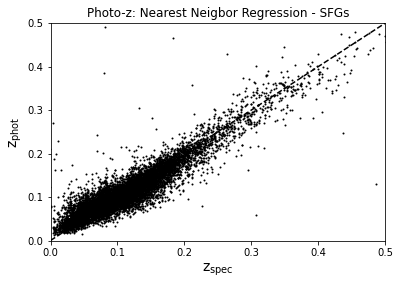

In [20]:
# Phot-Z Estimate - SFGs - kNN Estimate

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z)]).T

y = redshift

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.20)

n_neighbors = 10

knn = KNeighborsRegressor(n_neighbors, weights='uniform')

y_pred = knn.fit(x_train,y_train).predict(x_test)

axis_lim = np.array([0.0, 0.5])
ax = plt.axes()
plt.scatter(y_test,y_pred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.title('Photo-z: Nearest Neigbor Regression - SFGs')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

In [21]:
# Phot-Z Estimate - SFGs - kNN Performance

ztest=y_test
zpred=y_pred

sfg_del_z=(zpred-ztest)/(1+ztest)
sfg_mean=np.mean((zpred-ztest)/(1+ztest))
sfg_median=np.median((zpred-ztest)/(1+ztest))
sfg_RMS=np.std((zpred-ztest)/(1+ztest))
sfg_MAD=np.median(abs(sfg_del_z-np.median(sfg_del_z)))
sfg_NMAD=1.4826*sfg_MAD

print(sfg_mean,sfg_median,sfg_RMS,sfg_NMAD)

sfg_sig_1 = abs(sfg_del_z) > (1.*sfg_RMS)
sfg_sigma_1 = (float(len(sfg_del_z[sfg_sig_1]))/len(sfg_del_z))*100.

sfg_sig_2 = abs(sfg_del_z) > (2.*sfg_RMS)
sfg_sigma_2 = (float(len(sfg_del_z[sfg_sig_2]))/len(sfg_del_z))*100.

sfg_sig_3 = abs(sfg_del_z) > (3.*sfg_RMS)
sfg_sigma_3 = (float(len(sfg_del_z[sfg_sig_3]))/len(sfg_del_z))*100.

sfg_sig_5 = abs(sfg_del_z) > 0.05
sfg_sigma_5 = (float(len(sfg_del_z[sfg_sig_5]))/len(sfg_del_z))*100.

sfg_sig_10 = abs(sfg_del_z) > 0.10
sfg_sigma_10 = (float(len(sfg_del_z[sfg_sig_10]))/len(sfg_del_z))*100.

sfg_sig_15 = abs(sfg_del_z) > 0.15
sfg_sigma_15 = (float(len(sfg_del_z[sfg_sig_15]))/len(sfg_del_z))*100.

print(sfg_sigma_1,sfg_sigma_2,sfg_sigma_3,sfg_sigma_5,sfg_sigma_10,sfg_sigma_15)

0.0005050135980832457 0.00048485089319427754 0.02366358216545557 0.0174172128012744
21.36 3.5700000000000003 0.8500000000000001 2.97 0.36 0.18


In [22]:
# Phot-Z Estimate - AGNs - Data Query

NOBJECTS = 50000

query_text = ('\n'.join(
    ("SELECT TOP %i" % NOBJECTS,
    "   p.u, p.g, p.r, p.i, p.z, s.class, s.subclass, s.z as redshift, s.zerr as redshift_error, s.zwarning as redshift_warning",
    "FROM PhotoObj AS p",
    "   JOIN SpecObj AS s ON s.bestobjid = p.objid",
    "WHERE ",
    "       p.u BETWEEN 13.0 AND 22.15",
    "   AND p.g BETWEEN 13.0 AND 23.13",
    "   AND p.r BETWEEN 13.0 AND 22.70",
    "   AND p.i BETWEEN 13.0 AND 22.20",
    "   AND p.z BETWEEN 13.0 AND 20.71",
    "   AND s.zwarning = 0",
    "   AND s.class = 'QSO'")))

df = CasJobs.getPandasDataFrameFromQuery(query_text, "DR16")
 
df

,u,g,r,i,z,class,subclass,redshift,redshift_error,redshift_warning
0,21.57317,21.07390,20.99394,21.03825,20.52668,QSO,NaN,2.379001,0.000794,0
1,21.62744,20.85465,20.65615,20.52398,20.20635,QSO,BROADLINE,2.413624,0.000385,0
2,21.38125,20.76599,20.39421,20.11385,19.73923,QSO,BROADLINE,2.187754,0.000431,0
3,21.47820,20.79346,20.73192,20.49560,20.13710,QSO,BROADLINE,2.329659,0.000305,0
4,18.93237,18.20310,18.14979,18.11049,17.94795,QSO,BROADLINE,2.442198,0.000290,0
...,...,...,...,...,...,...,...,...,...,...
49995,20.76978,20.44538,20.44545,20.09386,20.07998,QSO,BROADLINE,1.543532,0.000471,0
49996,21.40691,21.18515,20.88025,20.41198,20.07818,QSO,NaN,1.901862,0.000801,0
49997,16.73111,16.37950,16.53901,16.39213,16.22396,QSO,BROADLINE,0.474082,0.000020,0
49998,20.85059,20.60929,20.10300,19.51060,18.83711,QSO,STARBURST BROADLINE,0.420778,0.000053,0


In [23]:
# Phot-Z Estimate - AGNs - Data Extraction

u = df['u']
g = df['g']
r = df['r']
i = df['i']
z = df['z']
class_in = df['class']
subclass_in = df['subclass']
redshift=df['redshift']

redshift

0        2.379001
1        2.413624
2        2.187754
3        2.329659
4        2.442198
           ...   
49995    1.543532
49996    1.901862
49997    0.474082
49998    0.420778
49999    1.958305
Name: redshift, Length: 50000, dtype: float64

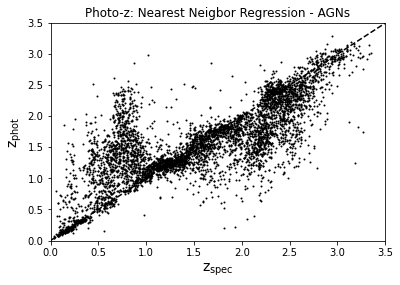

In [24]:
# Phot-Z Estimate - AGNs - kNN Estimate

x = np.vstack([np.array(r), np.array(u) - np.array(g), np.array(g) - np.array(r), np.array(r) - np.array(i), np.array(i) - np.array(z)]).T

y = redshift

indices = np.arange(x.shape[0])

x_train, x_test, y_train, y_test, i_train, i_test = train_test_split(x, y, indices, test_size=0.10)

n_neighbors = 10

knn = KNeighborsRegressor(n_neighbors, weights='uniform')

y_pred = knn.fit(x_train,y_train).predict(x_test)

axis_lim = np.array([0.0, 3.5])
ax = plt.axes()
plt.scatter(y_test,y_pred, c='k', lw=0, s=4)
plt.plot(axis_lim, axis_lim, '--k')
plt.xlim(axis_lim)
plt.ylim(axis_lim)
plt.title('Photo-z: Nearest Neigbor Regression - AGNs')
plt.xlabel(r'$\mathrm{z_{spec}}$', fontsize=14)
plt.ylabel(r'$\mathrm{z_{phot}}$', fontsize=14)
plt.show()

In [25]:
# Phot-Z Estimate - AGNs - kNN Performance

ztest=y_test
zpred=y_pred

agn_del_z=(zpred-ztest)/(1+ztest)
agn_mean=np.mean((zpred-ztest)/(1+ztest))
agn_median=np.median((zpred-ztest)/(1+ztest))
agn_RMS=np.std((zpred-ztest)/(1+ztest))
agn_MAD=np.median(abs(agn_del_z-np.median(agn_del_z)))
agn_NMAD=1.4826*agn_MAD

print(agn_mean,agn_median,agn_RMS,agn_NMAD)

agn_sig_1 = abs(agn_del_z) > (1.*agn_RMS)
agn_sigma_1 = (float(len(agn_del_z[agn_sig_1]))/len(agn_del_z))*100.

agn_sig_2 = abs(agn_del_z) > (2.*agn_RMS)
agn_sigma_2 = (float(len(agn_del_z[agn_sig_2]))/len(agn_del_z))*100.

agn_sig_3 = abs(agn_del_z) > (3.*agn_RMS)
agn_sigma_3 = (float(len(agn_del_z[agn_sig_3]))/len(agn_del_z))*100.

agn_sig_5 = abs(agn_del_z) > 0.05
agn_sigma_5 = (float(len(agn_del_z[agn_sig_5]))/len(agn_del_z))*100.

agn_sig_10 = abs(agn_del_z) > 0.10
agn_sigma_10 = (float(len(agn_del_z[agn_sig_10]))/len(agn_del_z))*100.

agn_sig_15 = abs(agn_del_z) > 0.15
agn_sigma_15 = (float(len(agn_del_z[agn_sig_15]))/len(agn_del_z))*100.

print(agn_sigma_1,agn_sigma_2,agn_sigma_3,agn_sigma_5,agn_sigma_10,agn_sigma_15)

0.055176168074183386 -0.002781827542902739 0.2556426336104481 0.10955515188946507
20.96 8.0 2.3800000000000003 59.8 42.88 33.72
